# Analyze posts

In [1]:
import datetime
import json
import matplotlib
import matplotlib.pyplot as plt
import os
import pandas as pd
import regex
import spacy
import sys
import unittest
import wordcloud
import IPython.display

from IPython.display import Image
from IPython.core.display import HTML
from sklearn.decomposition import PCA

sys.path.insert(0, '../scripts')
import tscore

In [2]:
POSTS_DIR = "../../posts"

In [3]:
nlp = spacy.load("nl_core_news_sm")

## 1. Check duplicate posts per batch

In [ ]:
def collect_posts(word=''):
    posts = {}
    for file_name in os.listdir(POSTS_DIR):
        if regex.search('-' + word + '\\.', file_name):
            with open(os.path.join(POSTS_DIR, file_name), "r") as infile:
                try:
                    data = json.load(infile)
                    infile.close()
                    posts[file_name] = [post['cid'] for post in data['posts']]
                except:
                    pass
    return posts

In [ ]:
def count_unique_posts(posts):
    unique_posts = set()
    for sample_time in posts.keys():
        duplicate_posts = set(posts[sample_time]) & unique_posts
        new_posts = set(posts[sample_time]).difference(duplicate_posts)
        unique_posts = unique_posts | new_posts
    return list(unique_posts)

In [ ]:
def compare_posts(posts, n=1):
    sample_times = sorted(posts.keys())
    overlap_counts = []
    for i in range(0, len(sample_times)):
        if i + n < len(sample_times):
            intersection = (set(posts[sample_times[i]]) & set(posts[sample_times[i + n]]))
            overlap_counts.append(len(intersection))
    print(f"min={min(overlap_counts):<2}", 
          f"max={max(overlap_counts):<3}", 
          f"avg={round(sum(overlap_counts) / len(overlap_counts), 1)}")

In [ ]:
for word in ['de','een','het','en','dat','van','niet','op','met','zijn',
             'voor','te','er','wel','als','aan','ze','zo','bij','geen']:
    posts = collect_posts(word=word)
    print(f"{word:>4}", end=" ")
    compare_posts(posts)

In [ ]:
len(count_unique_posts(posts))

## 2. Read posts from crawler files

In [4]:
JSON_POST_TEXTS_FILE_NAME = "post_texts.json"
JSON_POST_AUTHORS_FILE_NAME = "post_authors.json"
JSON_POST_HOURS_FILE_NAME = "post_hours.json"

In [ ]:
def save_post_texts_json(post_texts, outfile_name=JSON_POST_TEXTS_FILE_NAME):
    with open(outfile_name, "w") as outfile:
        json.dump(post_texts, outfile)
        outfile.close()

In [ ]:
def get_post_texts():
    post_texts = {}
    for file_name in os.listdir(POSTS_DIR):
        with open(os.path.join(POSTS_DIR, file_name), "r") as infile:
            try:
                data = json.load(infile)
                infile.close()
                for post in data['posts']:
                    date = post['record']['createdAt'][:10]
                    if date not in post_texts:
                        post_texts[date] = {}
                    if post['cid'] not in post_texts[date]:
                        post_texts[date][post['cid']] = post['record']['text']
            except:
                pass
            infile.close()
    return post_texts

In [ ]:
def get_post_authors():
    post_authors = {}
    for file_name in os.listdir(POSTS_DIR):
        with open(os.path.join(POSTS_DIR, file_name), "r") as infile:
            try:
                data = json.load(infile)
                infile.close()
                for post in data['posts']:
                    date = post['record']['createdAt'][:10]
                    if date not in post_authors:
                        post_authors[date] = {}
                    if post['cid'] not in post_authors[date]:
                        post_authors[date][post['cid']] = post['author']['handle']
            except:
                pass
            infile.close()
    return post_authors

In [ ]:
def get_post_hours():
    post_hours = {}
    for file_name in os.listdir(POSTS_DIR):
        with open(os.path.join(POSTS_DIR, file_name), "r") as infile:
            try:
                data = json.load(infile)
                infile.close()
                for post in data['posts']:
                    date = post['record']['createdAt'][:10]
                    hour = post['record']['createdAt'][11:13]
                    if date not in post_hours:
                        post_hours[date] = {}
                    if post['cid'] not in post_hours[date]:
                        post_hours[date][post['cid']] = hour
            except:
                pass
            infile.close()
    return post_hours

In [ ]:
post_texts = get_post_texts()

In [ ]:
post_authors = get_post_authors()

In [ ]:
post_hours = get_post_hours()

In [ ]:
del(post_texts['2024-11-23'])
del(post_authors['2024-11-23'])
del(post_hours['2024-11-23'])

In [ ]:
save_post_texts_json(post_texts, outfile_name=JSON_POST_TEXTS_FILE_NAME)
save_post_texts_json(post_authors, outfile_name=JSON_POST_AUTHORS_FILE_NAME)
save_post_texts_json(post_hours, outfile_name=JSON_POST_HOURS_FILE_NAME)

## 3. Read posts from json files

Requires names of json files defined under heading 2

In [5]:
def get_post_texts_json(infile_name=JSON_POST_TEXTS_FILE_NAME):
    with open(infile_name, "r") as infile:
        post_texts = json.load(infile)
        infile.close()
    return post_texts

In [6]:
post_texts = get_post_texts_json(infile_name=JSON_POST_TEXTS_FILE_NAME)
post_authors = get_post_texts_json(infile_name=JSON_POST_AUTHORS_FILE_NAME)
post_hours = get_post_texts_json(infile_name=JSON_POST_HOURS_FILE_NAME)

## 4. General post stats

In [7]:
def sanity_check_post_ids(post_texts):
    for date in post_texts.keys():
        for key in post_texts[date].keys():
            for date_2 in post_texts.keys():
                if date_2 != date and key in post_texts[date_2]:
                    print(f'duplicate key! {key} {date} {date_2}')

In [8]:
sanity_check_post_ids(post_texts)

In [9]:
print('Post counts per date:')
{date: len(post_texts[date]) for date in sorted(post_texts.keys())}

Post counts per date:


{'2024-11-24': 26794,
 '2024-11-25': 26730,
 '2024-11-26': 27793,
 '2024-11-27': 27685,
 '2024-11-28': 26689,
 '2024-11-29': 25750,
 '2024-11-30': 22997,
 '2024-12-01': 23766,
 '2024-12-02': 24571,
 '2024-12-03': 23941,
 '2024-12-04': 26212,
 '2024-12-05': 24243,
 '2024-12-06': 24477,
 '2024-12-07': 20808,
 '2024-12-08': 21330,
 '2024-12-09': 20631,
 '2024-12-10': 20968,
 '2024-12-11': 21028,
 '2024-12-12': 22508,
 '2024-12-13': 20535,
 '2024-12-14': 18610}

In [10]:
print('Total number of posts:', sum([len(post_texts[date]) for date in sorted(post_texts.keys())]))

Total number of posts: 498066


## 5. Search for topics: functions

In [14]:
def count_word(post_texts, word, exact_match=True):
    counts = {}
    for date in post_texts:
        if exact_match:
            counts[date] = len(["" for _, post_text in post_texts[date].items() 
                                if regex.search(f'\\b{word}\\b', post_text, regex.IGNORECASE)])
        else:
            counts[date] = len(["" for _, post_text in post_texts[date].items() 
                                if regex.search(f'{word}', post_text, regex.IGNORECASE)])
    print(f"Found {sum([counts[date] for date in counts])} posts")
    return dict(sorted(counts.items()))

In [15]:
def find_word(post_texts, post_hours, word, n=sys.maxsize, print_texts=False, exact_match=True, return_hours=False):
    counter = 0
    matched_texts = []
    for date in sorted(post_texts.keys()):
        for post_id, post_text in post_texts[date].items():
            if ((exact_match and regex.search(f'\\b{word}\\b', post_text, regex.IGNORECASE)) or
                (not exact_match and regex.search(f'{word}', post_text, regex.IGNORECASE))):
                if return_hours:
                    matched_texts.append(post_hours[date][post_id])
                else:
                    matched_texts.append(post_text)
                counter += 1
            if counter >= n:
                break
        if counter >= n:
            break
    if print_texts:
        for matched_text in matched_texts:
            post_text_date = f"{date} {matched_text}"
            matches = regex.finditer(f'\\b{word}\\b', post_text_date, regex.IGNORECASE)
            display(HTML(regex.sub('\\n', ' ', highlight(post_text_date, matches))))
            
    print(f"Found {'hours' if return_hours else 'texts'} for {counter} posts")
    return matched_texts

In [16]:
def save_plot(title):
    plt.savefig(regex.sub(' ', '_', regex.sub('"', '', title) + '.png'))

In [17]:
def bar_plot(counts, query=""):
    matplotlib.rc('font', **{'size':6})
    X = [datetime.datetime(int(x.split("-")[0]), 
                           int(x.split("-")[1]), 
                           int(x.split("-")[2])) for x in counts.keys()]
    y = counts.values()
    plt.bar(X, y)
    plt.xticks([datetime.datetime(2024, 11, 24),
                datetime.datetime(2024, 11, 30),
                datetime.datetime(2024, 12, 7),
                datetime.datetime(2024, 12, 14)])
    plt.title(f'Dutch Bluesky posts containing the phrase "{query}"')
    save_plot(query)
    plt.show()

In [18]:
def highlight(text, matches):
    matches_list = []
    for match in matches:
        matches_list = [match.span()] + matches_list
    for match in matches_list:
        end = match[1]
        text = text[:end] + '</font>' + text[end:]
        begin = match[0]
        text = text[:begin] + '<font color="blue">' + text[begin:]
    return text

In [19]:
stopwords=['de','het','een','die','dat','zijn','heeft','voor','van','hij','is','en','te','naar','niet','met','in','zo','lang','bij',
          'al','be','dan','daar','dan','aan','mij','zich','ook','heel','meer','moet','moeten','geen','waarin','lukken','via','analyse',
          'je','beeld','dus','eens','veel','wel','maken','gehouden','krijgt','bepaalde','onder','er','mensen','worden','hem','ons',
          'jaren','schijnt','houden','echt','jaar','net','minuut','over','nu','achter','wat','go','www','goed','tenslotte','op','als'
          'ik','ze','door','kan','tot','nog','maar','of','om','toch','deze','zal','the','wordt','gaat','willen','krijgen','wil','waar',
          'doet','alle','hier','wij','weer','hoe','alleen','tegen','grote','mijn','hebben','we','als','dit','gaat','komen','nl',
          'was','me','ben','na','zoals','lijkt','zelf','hun','ander','want','ander','wie','omdat','zien','mee','heb','nieuwe',
          'doen','zeker','uit','zou','gaan','kunnen','staat','nieuw','af','andere','u','mogelijk','even','anders','zonder','grootste',
          'zeggen','denk','komt','v','no','niets','toen','a','steeds','zegt','zelf','gewoon','vast','iets','zelfs','denken','helemaal',
          'zitten','zit','ik','s','podcast','tijd','haal','allemaal','vinden','misschien','erger','eerste','verder','geven','weg',
          'dag','ja','and','haar','hoop','soort','t','had','waarom','nieuws','land','with','beter','jullie','terug','kon','laat',
          'had verwacht','had','iedereen','straks','geweest','ad','rtl','altijd','laten',"z'n",'kijk','vooral','new','verwacht','vind',
          'deel','on','bijna','week','uur','gedaan','vanwege','alweer','onze','jou','eerst','voorbij','doen','lopen','kijken','valt',
          'gemaakt','enkel','blijft','ondanks','viel','beetje','m','loopt','keer','blijven','daarna','vanaf','houdt','nou','uren',
          'weet','ga','zie','jij','mag','krijg','horen','n','doe','vond','ging','vaak','zij','kunt','vanuit','moest','kun','he','oh',
          'zet','tussen','maak','kom','mij','jouw','waren','hebt','gehad','hadden','kreeg','zei','wilde','ziet','inmiddels','bent',
          'zouden','werd',"zo'n",'ken','werkt','aantal','snap','soms','word','vroeg','paar','ie','blijkbaar','weten','ah','ie','zat',
          'o','zag','nemen','eigen','vindt','geeft','sind','zetten','klopt','bluesky','bsky','social','https','zeg','helpt','elke',
          'staan']

In [20]:
def show_wordcloud(text, stopwords=stopwords, title=''):
    wc = wordcloud.WordCloud(stopwords=stopwords, width=1000, height=500).generate(text)
    plt.figure(figsize = (40,10))
    plt.imshow(wc)
    plt.axis('off')
    if title != '':
        plt.title(title)
    save_plot(title)
    plt.show()

In [21]:
def count_hashtags(matched_texts):
    hashtags = []
    for post_text in [post_text for post_text in matched_texts if regex.search('#', post_text)]:
        hashtags.extend([token.lower() for token in post_text.split() if regex.search('#', token)])
    return pd.Series(hashtags).value_counts()

In [22]:
def count_tokens(matched_texts):
    tokens = []
    for post_text in matched_texts:
        tokens.extend([token.lower() for token in post_text.split()])
    return pd.Series(tokens).value_counts()

## 6. Male vs female speech: comparison groups

In [39]:
def read_text_file(file_name):
    with open(file_name,'r') as infile:
        text = infile.read()
        infile.close()
    return text

In [40]:
authors = [author for date in post_authors for author in post_authors[date].values()]

In [41]:
author_counts = pd.Series(authors).value_counts()

In [42]:
male_names = read_text_file('male_names.txt').split()
female_names = read_text_file('female_names.txt').split()
other_names = read_text_file('other_names.txt').split()
classified = male_names + female_names + other_names
print(f'male: {len(male_names)} female:{len(female_names)}; unknown: {len(other_names)}')

male: 50 female:50; unknown: 100


In [43]:
[name for name in author_counts.keys() if name.split(".")[0] not in classified][:0]

[]

In [44]:
def get_author_text(post_authors, post_texts, name_list):
    author_text = ""
    for date in post_authors:
        for post_key in post_authors[date]:
            author_name = post_authors[date][post_key].split('.')[0]
            if author_name in name_list:
                author_text += "\n\n" + post_texts[date][post_key]
    return author_text

In [45]:
def make_tscore_data(token_counts):
    tscore_data = {'wordFreqs': {token: freq for token, freq in zip(token_counts.index, token_counts)}}
    tscore_data['totalFreq'] = sum([tscore_data['wordFreqs'][token] for token in tscore_data['wordFreqs'].keys()])
    tscore_data['nbrOfWords'] = len(tscore_data['wordFreqs'])
    return tscore_data

In [46]:
def compute_token_tscores(male_text, female_text):
    male_analysis = nlp(male_text)
    female_analysis = nlp(female_text)
    male_token_counts = pd.Series([str(token).lower() for token in male_analysis]).value_counts()
    female_token_counts = pd.Series([str(token).lower() for token in female_analysis]).value_counts()
    male_tscore_data = make_tscore_data(male_token_counts)
    female_tscore_data = make_tscore_data(female_token_counts)
    token_tscores =  tscore.computeTscore(male_tscore_data, female_tscore_data)
    return {token: score for token, score in sorted(token_tscores.items(), key=lambda pair: pair[1])}

In [47]:
male_text = get_author_text(post_authors, post_texts, male_names)
female_text = get_author_text(post_authors, post_texts, female_names)

In [48]:
token_tscores = compute_token_tscores(male_text, female_text)

In [49]:
print('Highly ranked tokens in posts of users with female names')
list(token_tscores.items())[:10]

Highly ranked tokens in posts of users with female names


[('!', -18.382682105774755),
 ('..', -18.079734318348073),
 ('ik', -15.998494426506651),
 ('\n', -12.45976184173866),
 ('️', -11.761423474381695),
 ('❤', -10.003223263091355),
 ('♀', -9.523717733522892),
 ('fijn', -8.943304405560832),
 ('mijn', -8.46607887268278),
 ('fijne', -8.18902616204051)]

In [50]:
print('Highly ranked tokens in posts of users with female names')
tscore_list = list(token_tscores.items())
tscore_list.reverse()
tscore_list[:10]

Highly ranked tokens in posts of users with female names


[('"', 18.344494801202845),
 ('de', 12.742044754450232),
 ('van', 10.87431082866408),
 ('wilders', 8.749688242039024),
 ('pvv', 7.728980603179812),
 ('vvd', 6.900505726796292),
 (':', 6.0137572920537785),
 ('heeft', 5.952136607220982),
 ('land', 5.663870592373189),
 ('is', 5.629421606900545)]

In [51]:
print('Highly ranked words in posts of users with female names')
female_words = [pair[0] for pair in token_tscores.items() if regex.search('[a-z]', pair[0])][:50]
female_words[:10]

Highly ranked words in posts of users with female names


['ik',
 'fijn',
 'mijn',
 'fijne',
 'lekker',
 'heb',
 'slaap',
 'mn',
 'hopelijk',
 'leuk']

In [52]:
print('Highly ranked words in posts of users with male names')
male_words = [pair[0] for pair in tscore_list if regex.search('[a-z]', pair[0])][:50]
male_words[:10]

Highly ranked words in posts of users with male names


['de',
 'van',
 'wilders',
 'pvv',
 'vvd',
 'heeft',
 'land',
 'is',
 'nederland',
 'partij']

## 7. Male vs female speech: comparison individuals

In [53]:
from sklearn.decomposition import PCA
pca_gender = PCA(n_components=5)

In [54]:
def make_token_vector(text, token_list):
    token_vector = [0] * len(token_list)
    nlp_analysis = nlp(text)
    for token in nlp_analysis:
        token = str(token).lower()
        if token in token_list:
            token_vector[token_list.index(token)] += 1
    token_count_sum = sum(token_vector)
    return [token_count / token_count_sum for token_count in token_vector]

In [60]:
def make_author_vectors(post_texts, post_authors, male_names, female_names):
    author_vectors = {}
    author_texts = {}
    for author_name in male_names + female_names:
        author_texts[author_name] = get_author_text(post_authors, post_texts, author_name)
        author_vectors[author_name] = make_token_vector(author_texts[author_name], male_words + female_words)
    return author_vectors

In [62]:
def compare_author_vectors(author_vectors):
    return pca_gender.fit_transform(list(author_vectors.values()))

In [64]:
best_factor = 4.28
best_offset = -0.02

def line_function(x, factor, offset):
    return factor * x + offset

In [61]:
author_vectors = make_author_vectors(post_texts, post_authors, male_names, female_names)

In [63]:
pca_gender_results = compare_author_vectors(author_vectors)

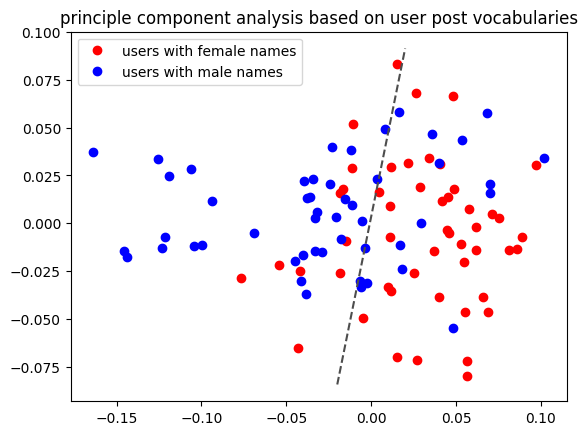

In [65]:
x = [pair[0] for pair in pca_gender_results]
y = [pair[1] for pair in pca_gender_results]
fig, ax = plt.subplots()
plt.plot(x[50:], y[50:], 'ro', label='users with female names')
plt.plot(x[:50], y[:50], 'bo', label='users with male names')
plt.plot((-0.02, 0.02), (line_function(-0.015, best_factor, best_offset), line_function(0.026, best_factor, best_offset)), ls="--", c=".3")
plt.title("principle component analysis based on user post vocabularies")
plt.legend()
plt.savefig("pcp.png")
plt.show()

In [66]:
def evaluate_line(factor, offset, x_list, y_list, names):
    score = 0
    for x, y, name in zip(x_list, y_list, names):
        y_line = factor * x + offset
        if (y >= y_line) and (name in names[:int(0.5*len(names))]):
            score += 1
        elif (y < y_line) and (name not in names[:int(0.5*len(names))]):
            score += 1
    return score

In [67]:
def test_line_position(factor, offset):
    no_improvement = False
    while not no_improvement:
        no_improvement = True
        score_base = evaluate_line(factor, offset, x, y, male_names + female_names)
        for increment in range(1, 2000):
            increment = round(increment / 1000, 2)
            if evaluate_line(factor, offset + increment, x, y, male_names + female_names) > score_base:
                offset += increment
                no_improvement = False
                continue
        for increment in range(-1, -2000, -1):
            increment = round(increment / 1000, 2)
            if evaluate_line(factor, offset + increment, x, y, male_names + female_names) > score_base:
                offset += increment
                no_improvement = False
                continue
        for increment in range(1, 2000):
            increment = round(increment / 1000, 2)
            if evaluate_line(factor + increment, offset, x, y, male_names + female_names) > score_base:
                factor += increment
                no_improvement = False
                continue
        for increment in range(-1, -2000, -1):
            increment = round(increment / 1000, 2)
            if evaluate_line(factor + increment, offset, x, y, male_names + female_names) > score_base:
                factor += increment
                no_improvement = False
                continue
    print(f'score: {score_base}; factor: {round(factor, 3)}; offset: {round(offset, 2)}')

In [68]:
for factor in [0.1, 0.2, 0.3, 0.4, 0.5, 0.75, 1, 1.5, 2, 2.5, 3, 5, 7, 10, 15, 20]:
    test_line_position(factor, 0)

score: 74; factor: 1.26; offset: -0.04
score: 74; factor: 1.25; offset: -0.04
score: 77; factor: 6.11; offset: -0.01
score: 74; factor: 0.63; offset: -0.03
score: 75; factor: 1.69; offset: 0.01
score: 74; factor: 1.02; offset: -0.03
score: 77; factor: 4.28; offset: -0.02
score: 75; factor: 1.68; offset: 0.01
score: 74; factor: 1.26; offset: -0.04
score: 77; factor: 4.36; offset: -0.02
score: 77; factor: 4.76; offset: -0.02
score: 77; factor: 4.28; offset: -0.02
score: 77; factor: 4.28; offset: -0.02
score: 76; factor: 9.41; offset: -0.06
score: 76; factor: 13.41; offset: -0.12
score: 76; factor: 19.02; offset: -0.19


## 8. Search for topics: tests

In [69]:
def smooth(my_list, n):
    smoothed_list = []
    for index in range(0, len(my_list)):
        list_min = max(0, index - n)
        list_max = min(len(my_list) - 1, index + n)
        smoothed_list.append(sum(my_list[list_min: list_max + 1]) / (list_max - list_min + 1))
    return smoothed_list

In [70]:
class TestNotebook(unittest.TestCase):    
    def test_smooth(self):
        self.assertEqual(smooth([1, 2, 3], 0), [1, 2, 3])
        self.assertEqual(smooth([1, 2, 3], 1), [1.5, 2, 2.5])
        self.assertEqual(smooth([1, 2, 3], 2), [2, 2, 2])

unittest.main(argv=[''], verbosity=2, exit=False)

test_smooth (__main__.TestNotebook.test_smooth) ... ok

----------------------------------------------------------------------
Ran 1 test in 0.001s

OK


In [71]:
def token_count(post_texts):
    matched_texts = find_word(post_texts, 
                              post_hours, 
                              "")
    return pd.Series(" ".join(matched_texts).lower().split()).value_counts()

In [72]:
print("Most frequent words:")
token_count(post_texts).head(10)

Most frequent words:
Found texts for 497740 posts


de     327201
het    222933
een    213017
en     201479
ik     189080
van    169931
dat    163163
is     143957
in     140602
je     111805
Name: count, dtype: int64

In [88]:
count = token_count(post_texts)

Found texts for 497740 posts


In [73]:
hashtag_counts = count_hashtags([post_texts[date][key] for date in post_texts.keys() for key in post_texts[date].keys()])

In [74]:
hashtag_counts.head(25)

#nieuws             4044
#rtlnieuws          1834
#algemeendagblad    1519
#ajax                554
#nos                 522
#sportnieuws         513
#top2000             403
#f1                  388
#pvv                 379
#dtv                 352
#vvd                 340
#natuur              298
#bbb                 265
#nsc                 265
#bluesky             263
#psv                 260
#efteling            248
#feyenoord           244
#nietinmijnnaam      240
#wilders             227
#photography         224
#fotovandedag        220
#sinterklaas         215
#snob2000            208
#fotografie          190
Name: count, dtype: int64

|   | count | word | English |
| - | ----- | ---- | ------- |
|  1 | 4883 | PVV* | Dutch political party |
|  2 | 4029 | Wilders* | Dutch politician |
|  3 | 3208 | oorlog* | war |
|  4 | 2364 | Trump* | Trump |
|  5 | 2347 | extreem* | extremism |
|  6 | 1961 | klimaat* | climate |
|  7 | 2518 | Israël* | Israel |
|  8 | 1359 | Oekraïne* | Ukraine |
|  9 | 1353 | democratie* | democracy |
| 10 | 1156 | vrijheid* | freedom |
| 11 | 1114 | racisme* | racism |
| 12 | 1098 | rechten* | rights |
| 13 | 1024 | gaza* | Gaza |
| 14 | 989 | genocide* | genocide |
| 15 | 814 | protest* | protest |
| 16 | 635 | milieu* | environment |
| 17 | 595 | discriminatie*| discrimination |
| 18 | 440 | woke*| woke |
| 19 | 141 | slavernij* | slavery |
| 20 | 105 | uitbuiting* | exploitation |
| 21 | 68 | MAGA | Make American Great Again |
| 22 | 19 | facisme* | facism |
| 23 | 16 | metoo | metoo |
| 24 | 10 | blm | black lives matter |
| 25 | 9 | America First | America First |

In [75]:
exact_match = False

for query in "pvv wilders oorlog trump extreem klimaat israël oekraïne democratie vrijheid racisme rechten gaza genocide protest milieu discriminatie woke slavernij uitbuiting facisme".split():
    print(query, end=' ')
    count_word(post_texts, query, exact_match=exact_match)

pvv Found 4883 posts
wilders Found 4029 posts
oorlog Found 3208 posts
trump Found 2364 posts
extreem Found 2347 posts
klimaat Found 1961 posts
israël Found 2518 posts
oekraïne Found 1359 posts
democratie Found 1353 posts
vrijheid Found 1156 posts
racisme Found 1114 posts
rechten Found 1098 posts
gaza Found 1024 posts
genocide Found 989 posts
protest Found 814 posts
milieu Found 635 posts
discriminatie Found 595 posts
woke Found 440 posts
slavernij Found 141 posts
uitbuiting Found 105 posts
facisme Found 19 posts


In [76]:
exact_match = True

for query in "maga metoo blm america_first".split():
    print(query, end=' ')
    count_word(post_texts, regex.sub('_', ' ', query), exact_match=exact_match)

maga Found 68 posts
metoo Found 16 posts
blm Found 10 posts
america_first Found 9 posts


In [77]:
def count_posts_per_hour(post_texts, post_hours):
    base_matched_hours = find_word(post_texts, 
                                                   post_hours, 
                                                   "", 
                                                   n=sys.maxsize, 
                                                   print_texts=False, 
                                                   exact_match=exact_match, 
                                                   return_hours=True)
    base_hour_data = pd.Series([int(x) for x in base_matched_hours]).value_counts()
    return base_hour_data

In [78]:
base_hour_data = count_posts_per_hour(post_texts, post_hours)

Found hours for 497740 posts


Found 1643 posts


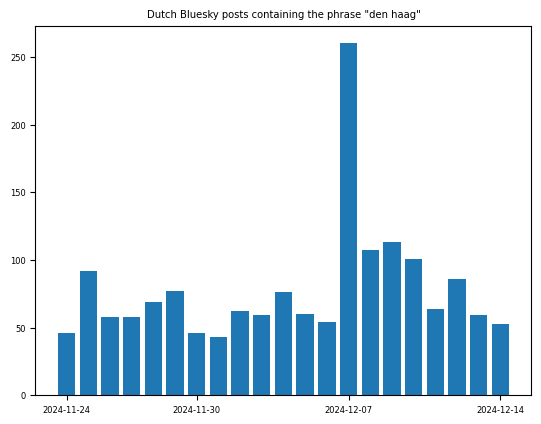

In [79]:
query = "den haag"
exact_match = True
bar_plot(count_word(post_texts, query, exact_match=exact_match), query=query)

In [80]:
matched_texts = find_word(post_texts, 
                          post_hours, 
                          query, 
                          n=sys.maxsize, 
                          print_texts=False, 
                          exact_match=exact_match, 
                          return_hours=False)

Found texts for 1643 posts


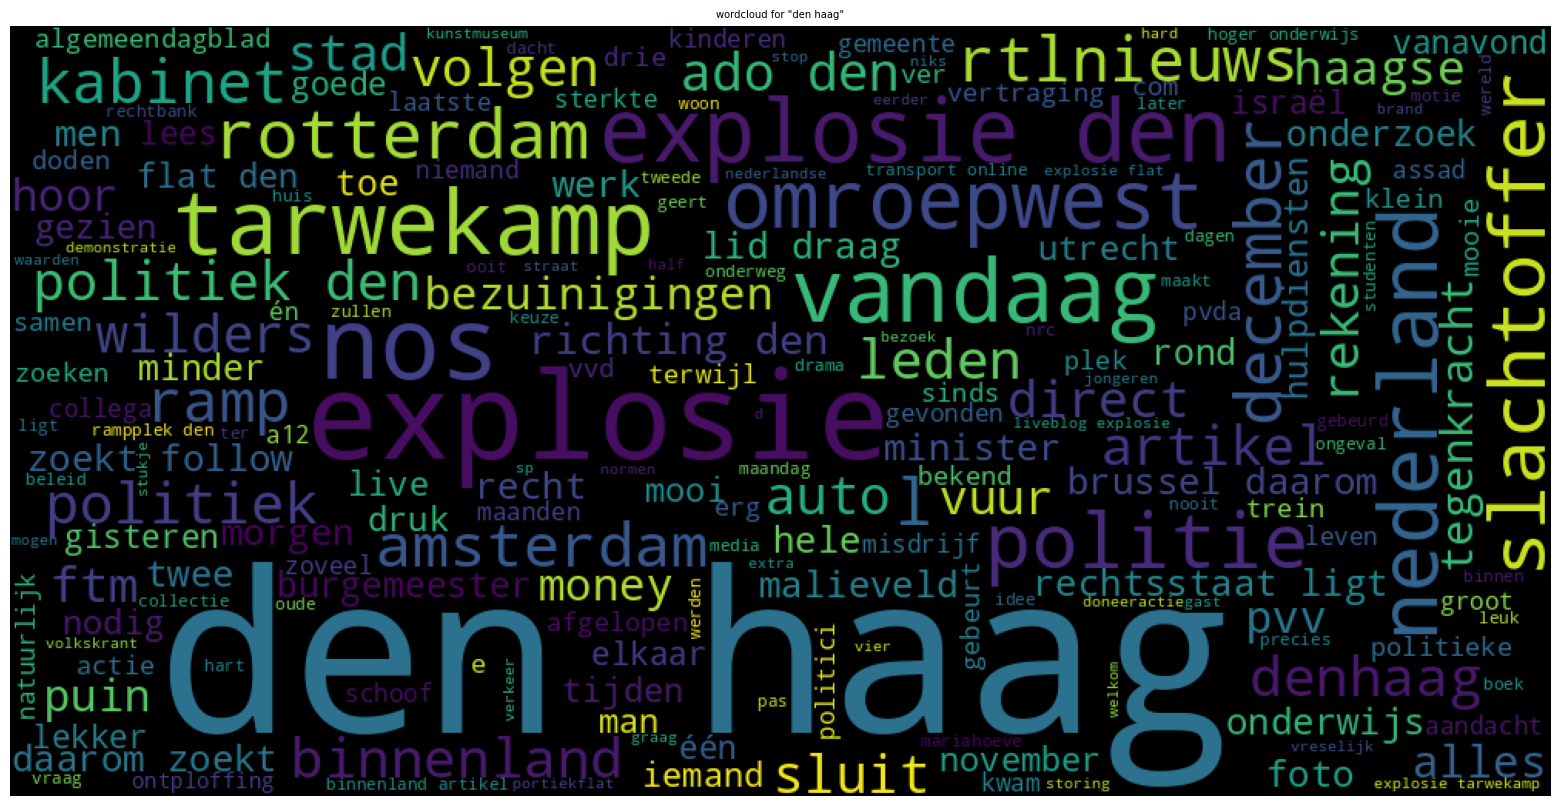

In [81]:
show_wordcloud(" ".join(matched_texts).lower(), stopwords=stopwords, title=f'wordcloud for "{query}"')

In [85]:
query = "slapen"

In [86]:
matched_hours = find_word(post_texts, 
                          post_hours, 
                          query, 
                          n=sys.maxsize, 
                          print_texts=False, 
                          exact_match=exact_match, 
                          return_hours=True)

Found hours for 1525 posts


In [83]:
def hour_plot(matched_hours, query=""):
    hour_data = pd.Series([int(x) for x in matched_hours]).value_counts()
    hour_data = {hour: hour_data[hour] / base_hour_data[hour] for hour in sorted(hour_data.keys())}
    x = hour_data.keys()
    y = smooth(list(hour_data.values()), 0)
    plt.figure(figsize=[5, 3.5])
    plt.plot(x, y, label=query)
    plt.xticks(range(0,24))
    plt.title(f'relative frequency of "{query}" per hour of the day')
    plt.savefig('fig.png')
    plt.show()

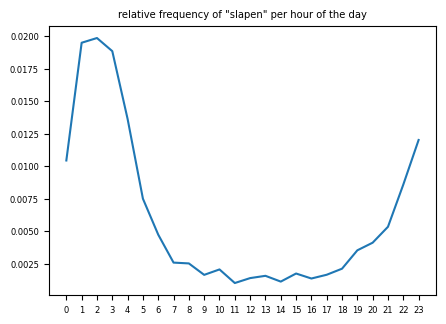

In [87]:
hour_plot(matched_hours, query=query)